In [4]:
!pip install qiskit qiskit_aer


--- Running BV with s=1011 and b=0 ---

Circuit:
         ┌───┐          ┌───┐          ┌─┐           
    q_0: ┤ H ├───────■──┤ H ├──────────┤M├───────────
         ├───┤┌───┐  │  └┬─┬┘          └╥┘           
    q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫────────────
         ├───┤└───┘  │   └╥┘      ┌───┐ ║      ┌─┐   
    q_2: ┤ H ├───────┼────╫────■──┤ H ├─╫──────┤M├───
         ├───┤       │    ║    │  └───┘ ║ ┌───┐└╥┘┌─┐
    q_3: ┤ H ├───────┼────╫────┼────■───╫─┤ H ├─╫─┤M├
         ├───┤┌───┐┌─┴─┐  ║  ┌─┴─┐┌─┴─┐ ║ └┬─┬┘ ║ └╥┘
    q_4: ┤ X ├┤ H ├┤ X ├──╫──┤ X ├┤ X ├─╫──┤M├──╫──╫─
         └───┘└───┘└───┘  ║  └───┘└───┘ ║  └╥┘  ║  ║ 
 c_in: 4/═════════════════╩═════════════╩═══╬═══╩══╩═
                          1             0   ║   2  3 
c_anc: 1/═══════════════════════════════════╩════════
                                            0        

Simulator counts:
{'1 1101': 1072, '0 1101': 976}


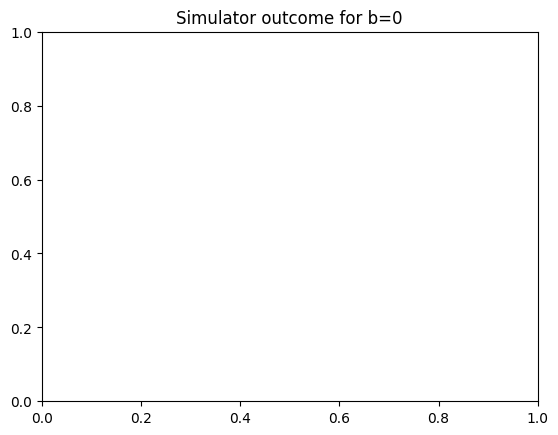

Fraction with input == s: 0/4096 = 0.0000
Approx ancilla distribution (heuristic): {'1': 3120, '0': 976}

--- Running BV with s=1011 and b=1 ---

Circuit:
         ┌───┐          ┌───┐          ┌─┐              
    q_0: ┤ H ├───────■──┤ H ├──────────┤M├──────────────
         ├───┤┌───┐  │  └┬─┬┘          └╥┘              
    q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫───────────────
         ├───┤└───┘  │   └╥┘      ┌───┐ ║      ┌─┐      
    q_2: ┤ H ├───────┼────╫────■──┤ H ├─╫──────┤M├──────
         ├───┤       │    ║    │  └───┘ ║ ┌───┐└╥┘┌─┐   
    q_3: ┤ H ├───────┼────╫────┼────■───╫─┤ H ├─╫─┤M├───
         ├───┤┌───┐┌─┴─┐  ║  ┌─┴─┐┌─┴─┐ ║ ├───┤ ║ └╥┘┌─┐
    q_4: ┤ X ├┤ H ├┤ X ├──╫──┤ X ├┤ X ├─╫─┤ X ├─╫──╫─┤M├
         └───┘└───┘└───┘  ║  └───┘└───┘ ║ └───┘ ║  ║ └╥┘
 c_in: 4/═════════════════╩═════════════╩═══════╩══╩══╬═
                          1             0       2  3  ║ 
c_anc: 1/═════════════════════════════════════════════╩═
                                               

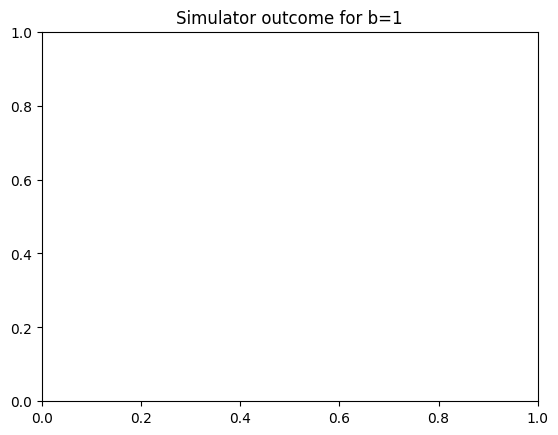

Fraction with input == s: 0/4096 = 0.0000
Approx ancilla distribution (heuristic): {'1': 3056, '0': 1040}

-- Ideal simulator --
{'0 1101': 2071, '1 1101': 2025}

-- Noisy simulator --
{'0 1000': 1, '0 0100': 1, '0 1101': 1960, '1 1101': 1949, '1 0100': 1, '1 0101': 24, '1 1100': 20, '0 0001': 22, '1 0000': 12, '0 0101': 27, '1 0001': 24, '0 1001': 13, '0 1100': 11, '1 1001': 18, '0 0000': 13}


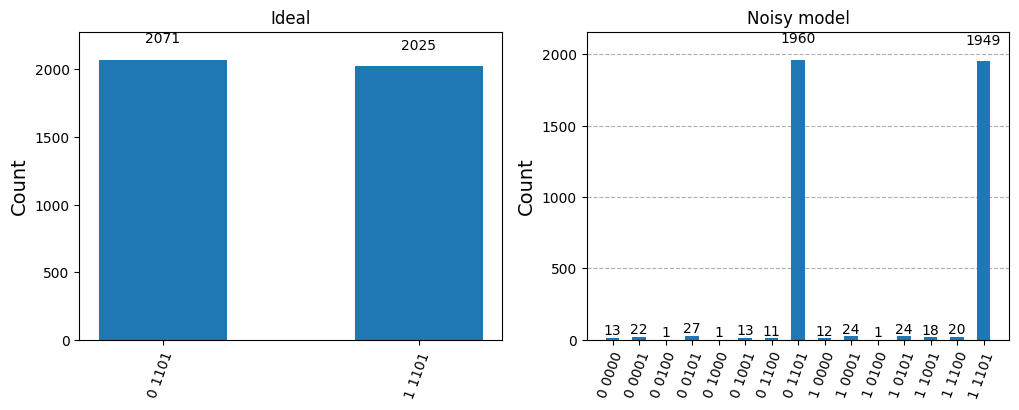

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np


def bv_oracle_with_b(qc: QuantumCircuit, input_qubits, ancilla_qubit, s: str, b: str):
    """Implements oracle for f(x) = s \u00b7 x \u2295 b.
    `s` is a string like '1011' (MSB indexed at input_qubits[0]).
    `b` is '0' or '1' (string for convenience).
    The oracle flips ancilla when s·x ⊕ b == 1.
    """

    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(input_qubits[i], ancilla_qubit)
    if b == '1':
        qc.x(ancilla_qubit)


def bernstein_vazirani_circuit(s: str, b: str, measure_ancilla: bool = True):
    n = len(s)
    qreg = QuantumRegister(n + 1, 'q')
    creg_in = ClassicalRegister(n, 'c_in')
    creg_anc = ClassicalRegister(1, 'c_anc') if measure_ancilla else None
    if measure_ancilla:
        qc = QuantumCircuit(qreg, creg_in, creg_anc)
    else:
        qc = QuantumCircuit(qreg, creg_in)

    inputs = list(range(n))
    ancilla = n

    qc.x(ancilla)
    qc.h(ancilla)
    for q in inputs:
        qc.h(q)

    bv_oracle_with_b(qc, inputs, ancilla, s, b)

    for q in inputs:
        qc.h(q)

    qc.measure(inputs, creg_in)
    if measure_ancilla:
        qc.measure(ancilla, creg_anc)

    return qc

def run_on_simulator(qc: QuantumCircuit, shots: int = 2048):
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

def simple_noise_model(p1=0.001, p2=0.01):
    nm = NoiseModel()
    e1 = depolarizing_error(p1, 1)
    e2 = depolarizing_error(p2, 2)
    nm.add_all_qubit_quantum_error(e1, ['h', 'x'])
    nm.add_all_qubit_quantum_error(e2, ['cx'])
    return nm

def run_on_noisy_simulator(qc: QuantumCircuit, shots: int = 2048, noise_model=None):
    if noise_model is None:
        noise_model = simple_noise_model()
    sim = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

def parse_counts(counts: dict, n_inputs: int, measure_ancilla: bool):
    parsed = {}
    for k, v in counts.items():
        key = k.replace(' ', '')
        if measure_ancilla:
            if len(key) == n_inputs + 1:
                anc_left = key[0]
                inputs_right = key[1:]
                anc_right = key[-1]
                inputs_left = key[:-1]
                parsed.setdefault((inputs_right, anc_left), 0)
                parsed[(inputs_right, anc_left)] += v
                parsed.setdefault((inputs_left, anc_right), 0)
                parsed[(inputs_left, anc_right)] += v
            else:
                parsed.setdefault((key, '?'), 0)
                parsed[(key, '?')] += v
        else:
            parsed.setdefault((k, None), 0)
            parsed[(k, None)] += v
    return parsed

if __name__ == '__main__':
    s = '1011'
    shots = 2048

    for b in ['0', '1']:
        print('\n--- Running BV with s={} and b={} ---'.format(s, b))
        qc = bernstein_vazirani_circuit(s, b, measure_ancilla=True)
        print('\nCircuit:')
        print(qc.draw(fold=120))

        counts = run_on_simulator(qc, shots=shots)
        print('\nSimulator counts:')
        print(counts)
        fig = plot_histogram(counts)
        plt.title(f'Simulator outcome for b={b}')
        plt.show()

        parsed = parse_counts(counts, len(s), True)
        input_success = 0
        total = 0
        for (inputs, anc), cnt in parsed.items():
            if inputs == s:
                input_success += cnt
            total += cnt
        print(f"Fraction with input == s: {input_success}/{total} = {input_success/total:.4f}")
        anc_counts = {}
        for (inputs, anc), cnt in parsed.items():
            anc_counts.setdefault(anc, 0)
            anc_counts[anc] += cnt
        print('Approx ancilla distribution (heuristic):', anc_counts)

if __name__ == '__main__':
    s = '1011'
    b = '1'
    qc = bernstein_vazirani_circuit(s, b, measure_ancilla=True)

    print('\n-- Ideal simulator --')
    counts_ideal = run_on_simulator(qc, shots=4096)
    print(counts_ideal)
    print('\n-- Noisy simulator --')
    nm = simple_noise_model(p1=0.002, p2=0.02)
    counts_noisy = run_on_noisy_simulator(qc, shots=4096, noise_model=nm)
    print(counts_noisy)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_histogram(counts_ideal, ax=axes[0])
    axes[0].set_title('Ideal')
    plot_histogram(counts_noisy, ax=axes[1])
    axes[1].set_title('Noisy model')
    plt.show()
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
    IBM_RUNTIME_AVAILABLE = True
except Exception:
    IBM_RUNTIME_AVAILABLE = False

if IBM_RUNTIME_AVAILABLE:
    def run_on_ibm(qc_list, backend_name: str = None, shots: int = 8192):
        # qc_list can be a single circuit or a list of circuits
        service = QiskitRuntimeService()  # uses local saved account or env vars
        sampler = Sampler(session=service, options={'shots': shots})
        # Sampler.run accepts circuits in a list
        if isinstance(qc_list, QuantumCircuit):
            circuits = [qc_list]
        else:
            circuits = qc_list
        job = sampler.run(circuits)
        result = job.result()
        try:
            quasi = result.quasi_dists
            counts_list = []
            for qd in quasi:
                # qd is a dict{'0...': prob, ...}
                counts_list.append({k: int(round(v * shots)) for k, v in qd.items()})
            return counts_list
        finally:
            sampler.close()

else:
    pass